# PCA

This notebook covers performing Principal Component Analysis on the dataset, and the interpretation of these components. 

In [10]:
# Libraries
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from itertools import product


# Load data

In [11]:

train_data = np.load("data/fashion_train.npy")
X_train, y_train = train_data[:,:784], train_data[:,-1]

test_data = np.load("data/fashion_test.npy")
X_test, y_test = test_data[:,:784], test_data[:,-1]

N_CLASSES = len(np.unique(y_train))
CLOTHING_TYPES = {0: "T-shirt/top", 
                  1: "Trouser",
                  2: "Pullover",
                  3: "Dress",
                  4: "Shirt"}


# Perform PCA

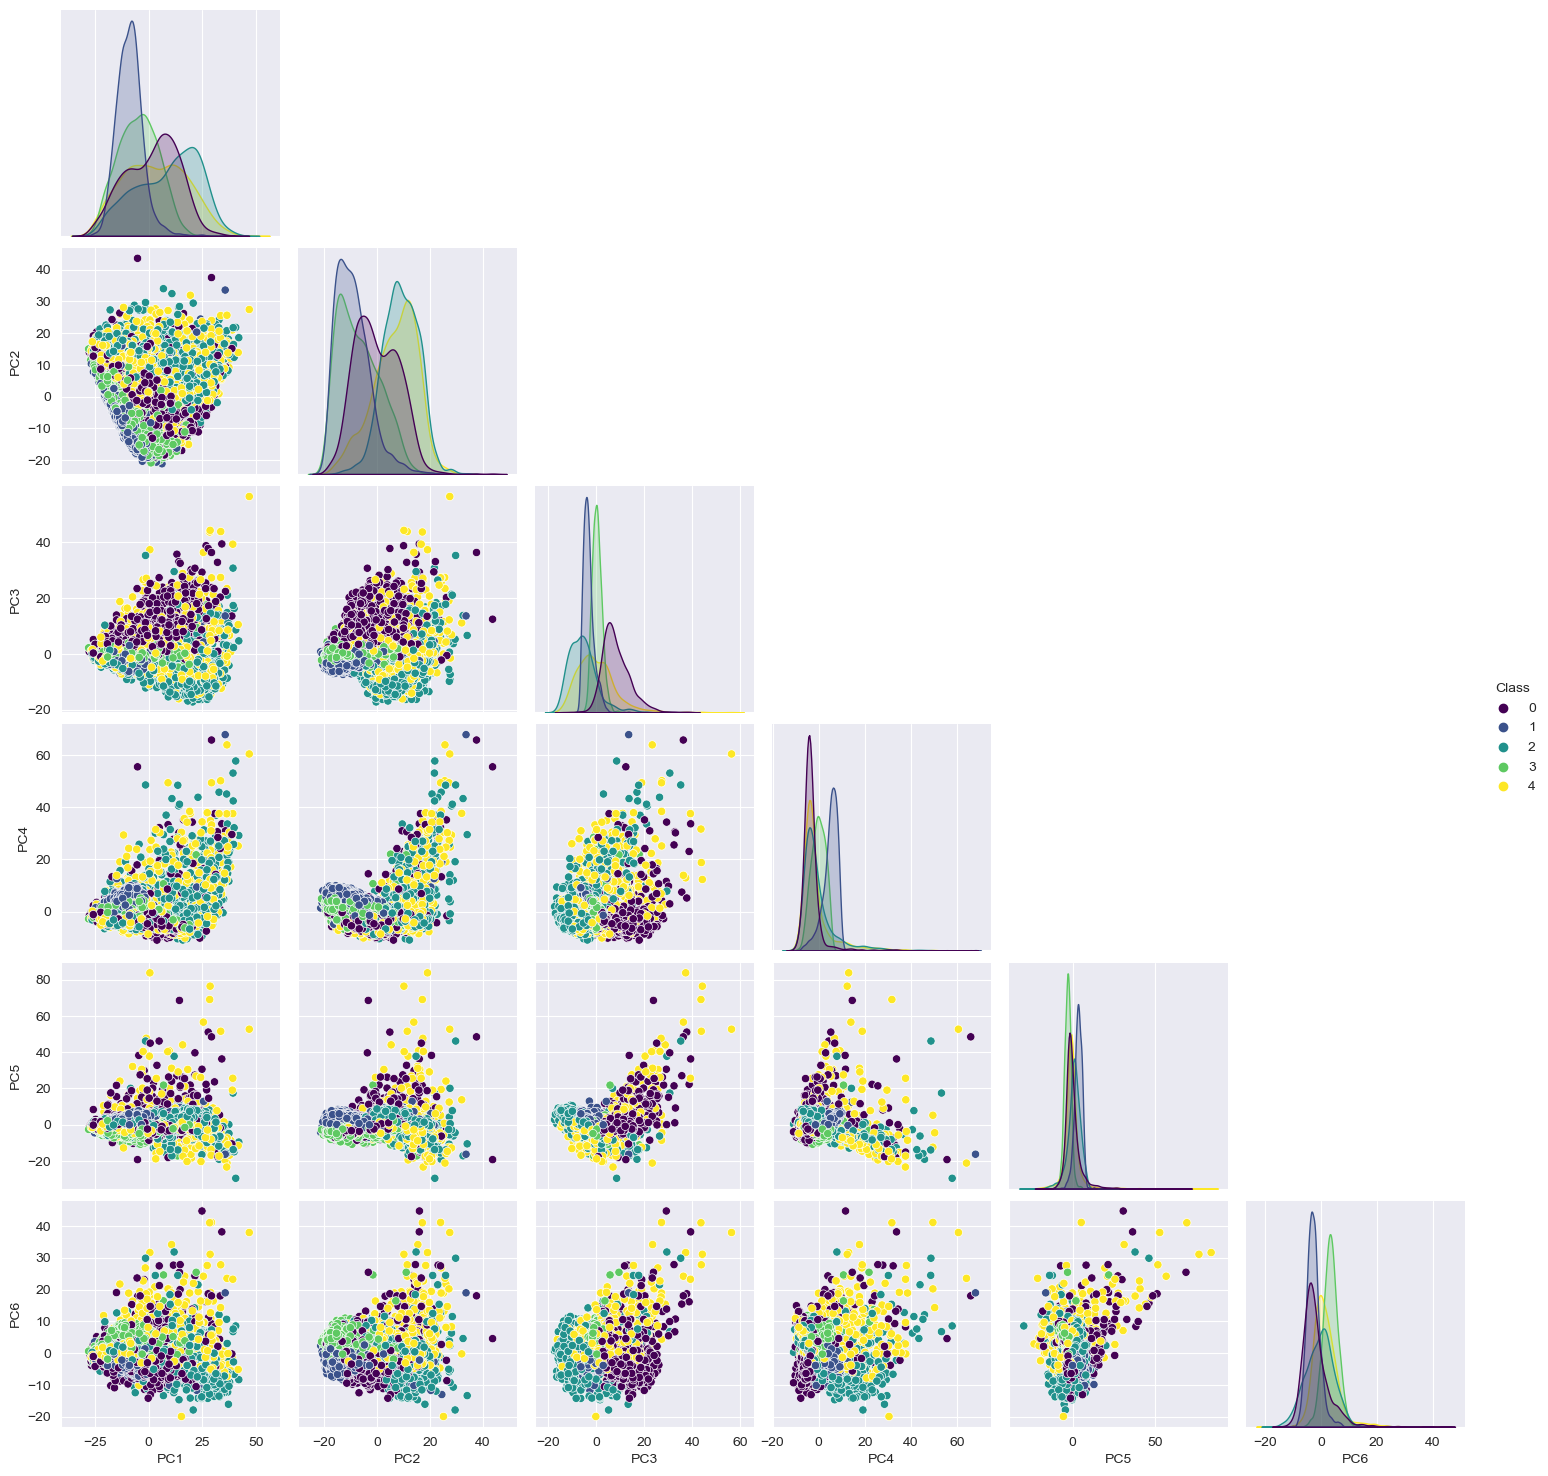

In [12]:
num_components = 6
pca = PCA(n_components=num_components)

# Standardizing each feature to have mean 0 and variance 1 both for the training and test set
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)
X_test_standardized = scaler.transform(X_test)

# Fitting the PCA model on the training data and transform it
projected_X_train = pca.fit_transform(X_train_standardized)

# 'projected_X_train' and 'projected_X_test' now contain the data in the reduced dimensionality

# If you want to access the principal components and explained variance
principal_components = pca.components_
explained_variance = pca.explained_variance_
cumulative_variance = np.cumsum(pca.explained_variance_)

# Concatenate the principal components with the class information for plotting
pc_df = pd.DataFrame(data=projected_X_train[:,:num_components], columns=[f'PC{i+1}' for i in range(num_components)])
pc_df['Class'] = y_train  # Assuming the class information is in the first column of Y_train

# Use seaborn's pairplot for scatterplot matrix with hue for coloring
sns.pairplot(pc_df, hue='Class', palette='viridis', markers='o', corner=True)

plt.show()

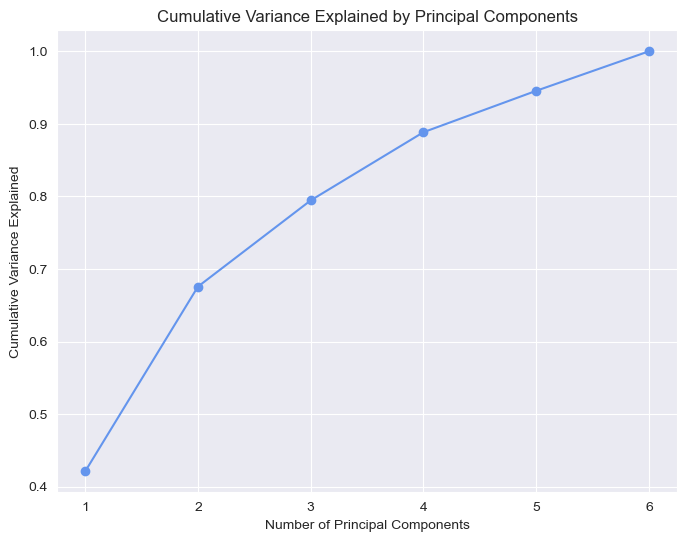

In [13]:
# Plot the cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_components + 1), cumulative_variance / np.sum(pca.explained_variance_), marker='o', linestyle='-', color='cornflowerblue')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.title('Cumulative Variance Explained by Principal Components')
plt.grid(True)
plt.show()

In [14]:
pca_picked = pc_df[["PC1","PC2","Class"]]
pca_picked

,PC1,PC2,Class
0,-0.504663,2.608573,0
1,-18.182703,0.285265,1
2,5.345144,-2.348569,0
3,-11.084712,1.340172,3
4,-1.613810,10.749582,4
...,...,...,...
9995,-0.217050,1.450272,4
9996,5.881807,-2.474948,0
9997,-4.364422,-15.213182,3
9998,-0.531598,-1.086622,0


In [25]:
n_points = 5

points_space_pc1 = np.linspace(start=-10, stop=20, num=n_points)
points_space_pc2 = np.linspace(start=-10, stop=20, num=n_points)

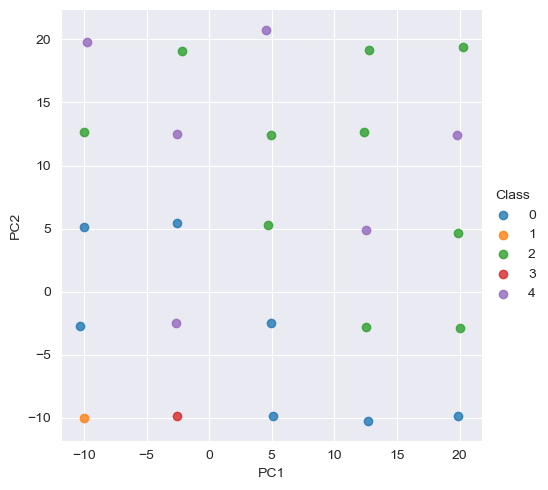

In [26]:
points = []

dist = lambda a,b: np.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)

tolerance = 100

for pc1, pc2 in list(product(points_space_pc1,points_space_pc2)):
    pc1_close = np.isclose(pca_picked["PC1"],pc1, atol=tolerance)
    pc2_close = np.isclose(pca_picked["PC2"],pc2, atol=tolerance)
    
    filtered_pca_data = pca_picked[pc1_close & pc2_close].copy()
    filtered_pca_data["dist_to_gridpos"] = dist(a=[filtered_pca_data["PC1"], filtered_pca_data["PC2"]], b=[pc1,pc2])
    
    points.append(int(filtered_pca_data.idxmin().dist_to_gridpos))


sns.lmplot(data=pca_picked.iloc[points], x="PC1",y="PC2",hue="Class", fit_reg=False);


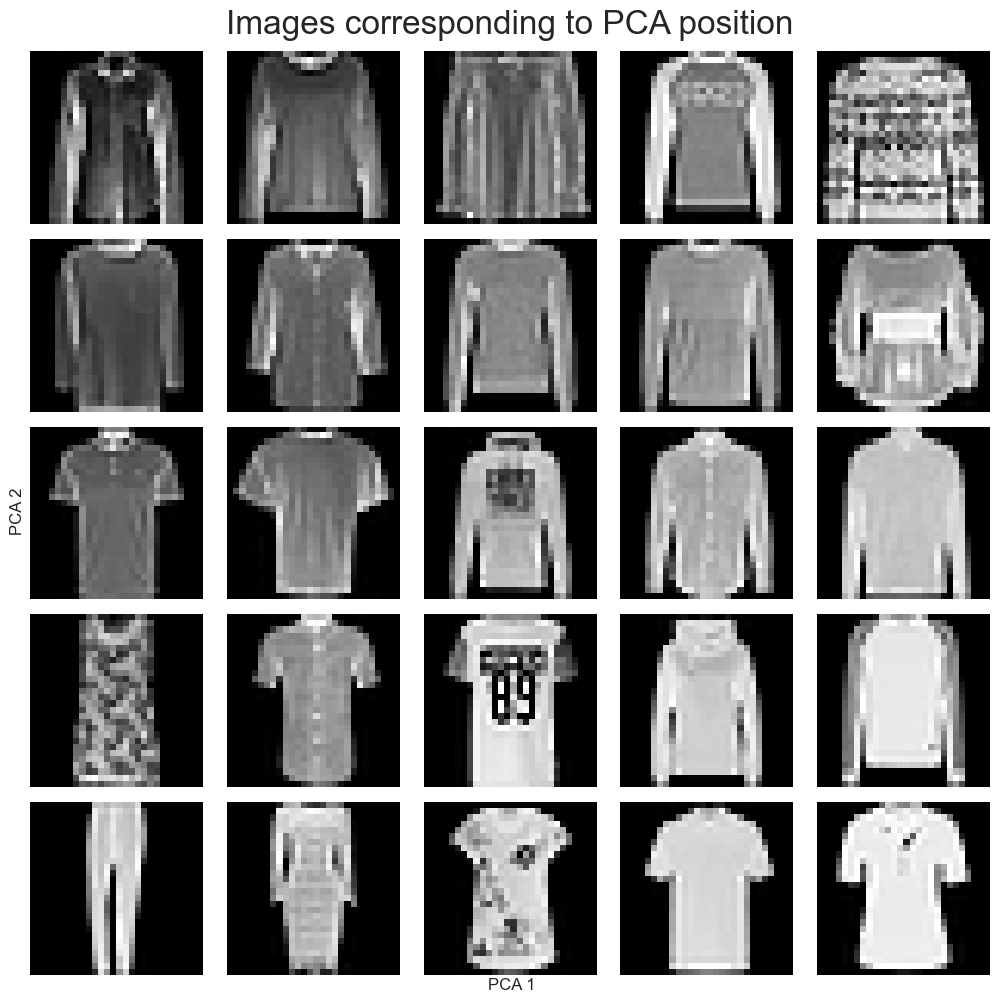

In [27]:

pca_interpretation_X_train = np.flip(X_train[points,:].reshape(n_points,n_points,28,28),1)



fig, ax = plt.subplots(ncols=n_points, nrows=n_points, figsize=(10,10))

for i in range(n_points):
    for j in range(n_points):
        ax[j][i].imshow(pca_interpretation_X_train[i,j,:,:], cmap="gray")
        ax[j][i].set_axis_off()


fig.suptitle("Images corresponding to PCA position", fontsize=24)
fig.text(0.478, 0, "PCA 1", fontsize=12)
fig.text(0, 0.458, "PCA 2", fontsize=12,rotation = "vertical")
fig.tight_layout()



# PCA Eigenvectors

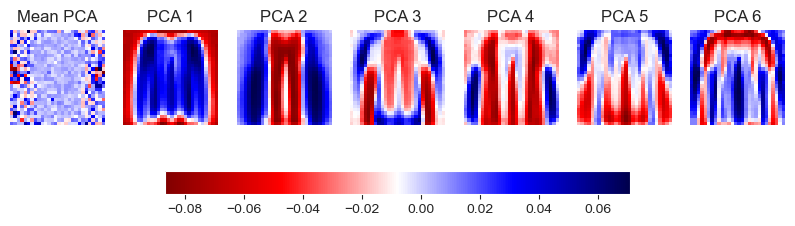

In [ ]:
fig,ax = plt.subplots(ncols=7, figsize = [10,4])

cmap = plt.get_cmap("seismic_r")
ax[0].imshow(pca.mean_.reshape(28,28), cmap=cmap)
ax[0].set_axis_off()
ax[0].set_title("Mean PCA")

for i in range(1,7):
    ax[i].imshow(pca.components_[i-1].reshape(28,28), cmap=cmap)
    ax[i].set_axis_off()
    ax[i].set_title(f"PCA {i}")


sm = ScalarMappable(cmap=cmap)
sm.set_array(pca.components_[i-1])
cbar = plt.colorbar(sm,ax=ax,shrink=0.6, orientation="horizontal", location="bottom")
cbar.ax.xaxis.set_ticks_position('bottom')




We see that PCA 1 tries to substract some of the outer pixels. It adds the middle ones, and we generally see t-shirts shapes, and we can also see some pants. PCA 2 substracts pant shapes. It also tries to add sleeves to the mean image. PCA 3 Adds shoulders, and substracts long sleeves. It also adds longer shirts. PCA 4 substracts long narrow sleeves (close to the body), and adds long broad sleeves (away from the body).